<span style="color:#4FA3FF; font-weight:700; font-size:120%">Optimización de Portafolios con Markowitz mediante Simulación Monte Carlo</span>

<span style="color:#4FA3FF; font-weight:700">Descripción breve:</span>

Este trabajo presenta una metodología práctica para **optimizar portafolios** utilizando el enfoque de **Markowitz** combinado con **Simulación Monte Carlo**. A partir de datos históricos obtenidos con `yfinance` se generan múltiples combinaciones de pesos para estimar el **retorno esperado**, la **volatilidad** y el **Ratio de Sharpe**.

El objetivo es identificar la **combinación más eficiente** (máximo Sharpe) y construir la **frontera eficiente** para facilitar la toma de decisiones según distintos perfiles de riesgo.

<span style="color:#4FA3FF; font-weight:700">Componentes esenciales</span>

<span style="color:#4FA3FF; font-weight:700">Datos y Preparación</span>

Se emplean ETFs y acciones reales (por ejemplo: GOOGL, NVDA, MSFT, entre otros).

Se obtienen precios históricos a través de `yfinance` y se calculan retornos diarios, que sirven como base para las simulaciones.

<span style="color:#4FA3FF; font-weight:700">Simulación Monte Carlo</span>

Se generan 100.000 (configurable) combinaciones aleatorias de pesos entre los activos. Para cada portafolio se estiman:

- **Retorno esperado**
- **Volatilidad total**
- **Ratio de Sharpe** (medida de eficiencia riesgo-rendimiento)

<span style="color:#4FA3FF; font-weight:700">Optimización</span>

Se identifica el portafolio con mayor **Sharpe Ratio**, considerado el más eficiente bajo las suposiciones del modelo.

Se construye la **frontera eficiente** y los resultados se visualizan con un gráfico de dispersión riesgo-retorno (volatilidad vs. retorno) con el Sharpe codificado por color.

<span style="color:#4FA3FF; font-weight:700">Aplicación práctica</span>

El programa permite:

- Determinar la combinación óptima de activos según la muestra histórica.
- Analizar visualmente la relación **riesgo vs rendimiento**.
- Evaluar el nivel de diversificación del portafolio.
- Ajustar decisiones según el perfil de riesgo del inversor y parámetros (p. ej. tasa libre de riesgo, número de simulaciones).

<span style="color:#4FA3FF; font-weight:700">Consideraciones</span>

- Las conclusiones dependen de datos históricos y de la ventana temporal analizada.
- Se asume una distribución aproximada de retornos (limitación del modelo).
- Los pesos en esta versión son solo positivos (sin posiciones cortas).
- Se recomienda rebalanceo periódico y validación con escenarios fuera de muestra.

(Los bloques siguientes contienen el código para descargar datos, calcular retornos, ejecutar la simulación Monte Carlo y graficar la frontera eficiente).

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Descarga los precios históricos ajustados de los activos seleccionados (maneja cambios en yfinance)
def obtener_precios_activos(activos, inicio_periodo, fin_periodo):
    marco_precios = pd.DataFrame()
    for activo in activos:
        # Solicita los datos sin modificar automáticamente los precios (auto_adjust=False)
        datos_crudos = yf.download(activo, start=inicio_periodo, end=fin_periodo, auto_adjust=False)
        # yfinance puede devolver DataFrame con columna 'Adj Close' o solo 'Close'.
        # Seleccionamos 'Adj Close' si existe, sino 'Close'. Si la respuesta es una Series, la usamos directamente.
        if isinstance(datos_crudos, pd.Series):
            serie_precios = datos_crudos
        else:
            if 'Adj Close' in datos_crudos.columns:
                serie_precios = datos_crudos['Adj Close']
            elif 'Close' in datos_crudos.columns:
                serie_precios = datos_crudos['Close']
            else:
                # Fallback: tomar la primera columna disponible
                serie_precios = datos_crudos.iloc[:, 0]
        marco_precios[activo] = serie_precios
    return marco_precios

# Definición de los activos y parámetros de consulta
acciones = ["GOOGL", "ASML", "MOH", "ORLA",
                    "NVDA", "META", "PG", "PDD"
]

inicio_periodo = '2019-01-01'
fin_periodo = '2025-01-01'

# Obtiene los datos históricos para los activos definidos
precios_historicos = obtener_precios_activos(acciones, inicio_periodo, fin_periodo)

precios_historicos.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,GOOGL,ASML,MOH,ORLA,NVDA,META,PG,PDD
Date,,,,,,,,
2019-01-02,52.338543,145.733444,112.889999,0.795,3.377166,134.848694,76.454636,22.209999
2019-01-03,50.888996,137.696167,105.900002,0.872,3.173128,130.932846,75.918587,21.520000
2019-01-04,53.499275,143.654236,109.660004,0.872,3.376423,137.104797,77.468117,22.690001
2019-01-07,53.392582,146.936234,117.750000,0.875,3.555173,137.204178,77.158203,23.209999
2019-01-08,53.861538,145.854645,128.309998,0.875,3.466665,141.656738,77.442970,24.000000


In [3]:
# Calcula los retornos diarios simples de cada activo
retornos_diarios = precios_historicos.pct_change()  # Retornos porcentuales diarios

retornos_diarios.head()

,GOOGL,ASML,MOH,ORLA,NVDA,META,PG,PDD
Date,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.027696,-0.055151,-0.061919,0.096855,-0.060417,-0.029039,-0.007011,-0.031067
2019-01-04,0.051294,0.043270,0.035505,0.000000,0.064068,0.047138,0.020410,0.054368
2019-01-07,-0.001994,0.022847,0.073773,0.003440,0.052941,0.000725,-0.004001,0.022918
2019-01-08,0.008783,-0.007361,0.089682,0.000000,-0.024896,0.032452,0.003691,0.034037


In [4]:
# Simulación Monte Carlo para portafolios aleatorios

# Parámetros principales de la simulación
cantidad_muestras = 100000
tasa_libre_riesgo = 0.04  # Tasa libre de riesgo anual (4%)

# Inicializa los arreglos para almacenar los resultados de cada portafolio
pesos_portafolio = np.zeros((cantidad_muestras, len(acciones)))
retornos_portafolios = np.zeros(cantidad_muestras)
volatilidades_portafolios = np.zeros(cantidad_muestras)
razones_sharpe = np.zeros(cantidad_muestras)

# Ejecuta la simulación generando portafolios aleatorios
for iteracion in range(cantidad_muestras):
    # Genera pesos aleatorios y los normaliza para que sumen 1
    pesos_aleatorios = np.random.random(len(acciones))
    pesos_normalizados = pesos_aleatorios / np.sum(pesos_aleatorios)
    pesos_portafolio[iteracion, :] = pesos_normalizados
    
    # Calcula el retorno anual esperado del portafolio
    retorno_esperado = np.sum(retornos_diarios.mean() * pesos_normalizados) * 252
    retornos_portafolios[iteracion] = retorno_esperado
    
    # Calcula la volatilidad anual del portafolio
    volatilidad_esperada = np.sqrt(
        np.dot(pesos_normalizados.T, np.dot(retornos_diarios.cov() * 252, pesos_normalizados))
    )
    volatilidades_portafolios[iteracion] = volatilidad_esperada
    
    # Calcula el Ratio de Sharpe para el portafolio
    razones_sharpe[iteracion] = (retorno_esperado - tasa_libre_riesgo) / volatilidad_esperada

In [5]:
# Identifica el portafolio óptimo según el mayor Ratio de Sharpe
indice_mejor = razones_sharpe.argmax()
pesos_mejor = pesos_portafolio[indice_mejor, :]
retorno_mejor = retornos_portafolios[indice_mejor]
volatilidad_mejor = volatilidades_portafolios[indice_mejor]
sharpe_mejor = razones_sharpe[indice_mejor]

# Crea un DataFrame con los resultados de todos los portafolios simulados
resultados_simulacion = pd.DataFrame({
    'Return': retornos_portafolios,
    'Volatility': volatilidades_portafolios,
    'Sharpe Ratio': razones_sharpe
})

![Markowitz](Graficos/MarkImage.png)

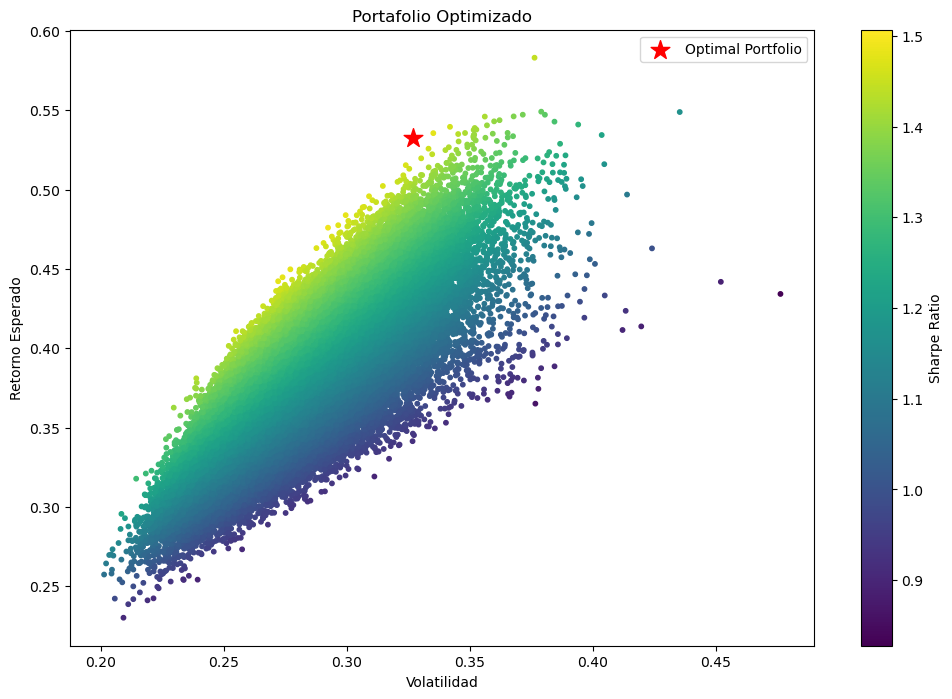


Portafolio Optimizado:
--------------------
Retorno Esperado: 53.23%
Volatilidad: 32.67%
Ratio de Sharpe: 1.51

Pesos óptimos:
GOOGL: 1.87%
ASML: 0.24%
MOH: 5.00%
ORLA: 22.05%
NVDA: 43.54%
META: 3.17%
PG: 15.06%
PDD: 9.07%


In [6]:
# Frontera eficiente y el portafolio óptimo
plt.figure(figsize=(12,8))
plt.scatter(volatilidades_portafolios, retornos_portafolios, c=razones_sharpe, cmap='viridis', marker='o', s=10)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(volatilidad_mejor, retorno_mejor, color='red', marker='*', s=200, label='Optimal Portfolio')
plt.xlabel('Volatilidad')
plt.ylabel('Retorno Esperado')
plt.title('Portafolio Optimizado')
plt.legend()
plt.show()

# Muestra los resultados del portafolio óptimo
print("\nPortafolio Optimizado:")
print("--------------------")
print(f"Retorno Esperado: {retorno_mejor*100:.2f}%")
print(f"Volatilidad: {volatilidad_mejor*100:.2f}%")
print(f"Ratio de Sharpe: {sharpe_mejor:.2f}")
print("\nPesos óptimos:")
for activo, peso in zip(acciones, pesos_mejor):
    print(f"{activo}: {peso*100:.2f}%")